<a href="https://colab.research.google.com/github/cevateness/set_partitioning_problem/blob/main/spp_algos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
!pip install pulp
!pip install ortools

In [53]:
import random

def is_feasible_solution_set(elements, subsets):
    covered_elements = set()
    for subset in subsets:
        covered_elements.update(subset["set"])
    return covered_elements == elements

def generate_problem_instance(num_elements, num_subsets):
    elements = set(range(1, num_elements + 1))
    while True:
        subsets = []
        for _ in range(num_subsets):
            subset_size = random.randint(1, num_elements // 2)  # Random subset size
            subset_elements = set(random.sample(elements, subset_size))
            cost = random.randint(1, 10)  # Random cost for the subset
            subsets.append({"set": subset_elements, "cost": cost})

        # Check if the generated instance is feasible
        if is_feasible_solution_set(elements, subsets):
            break  # If feasible, break the loop and return the instance

    return elements, subsets

# Example usage
num_elements = 8
num_subsets = 15

elements, subsets = generate_problem_instance(num_elements, num_subsets)

print("Generated Elements:", elements)
print("Generated Subsets:")
for i, subset in enumerate(subsets):
    print(f"Subset {i + 1}: {subset}")


Generated Elements: {1, 2, 3, 4, 5}
Generated Subsets:
Subset 1: {'set': {4}, 'cost': 1}
Subset 2: {'set': {1, 3}, 'cost': 5}
Subset 3: {'set': {1}, 'cost': 1}
Subset 4: {'set': {1, 3}, 'cost': 10}
Subset 5: {'set': {1, 3}, 'cost': 7}
Subset 6: {'set': {3}, 'cost': 2}
Subset 7: {'set': {5}, 'cost': 6}
Subset 8: {'set': {3}, 'cost': 7}
Subset 9: {'set': {1, 3}, 'cost': 3}
Subset 10: {'set': {5}, 'cost': 4}
Subset 11: {'set': {1}, 'cost': 3}
Subset 12: {'set': {5}, 'cost': 6}
Subset 13: {'set': {4, 5}, 'cost': 7}
Subset 14: {'set': {1, 4}, 'cost': 10}
Subset 15: {'set': {2, 4}, 'cost': 10}
Subset 16: {'set': {1, 5}, 'cost': 7}
Subset 17: {'set': {4}, 'cost': 3}
Subset 18: {'set': {3}, 'cost': 6}
Subset 19: {'set': {1}, 'cost': 8}
Subset 20: {'set': {1}, 'cost': 10}
Subset 21: {'set': {5}, 'cost': 8}
Subset 22: {'set': {3, 4}, 'cost': 6}
Subset 23: {'set': {2}, 'cost': 2}
Subset 24: {'set': {1, 5}, 'cost': 9}
Subset 25: {'set': {4, 5}, 'cost': 3}


<ipython-input-53-b014870056ee>:15: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  subset_elements = set(random.sample(elements, subset_size))


In [54]:
import itertools
import numpy as np

# Helper function to check if a solution is feasible (covers all elements exactly once)
def is_feasible_solution(solution, elements):
    # Combine all the selected subsets
    covered_elements = set()
    for subset in solution:
        covered_elements.update(subset['set'])

    # Ensure that all elements are covered exactly once
    if covered_elements != elements:
        return False

    # Check that no element is covered more than once
    for elem in elements:
        count = sum([1 for subset in solution if elem in subset['set']])
        if count != 1:
            return False

    return True

# Brute-force approach (exhaustive search) to find the optimal solution
def brute_force_solution():
    min_cost = float('inf')
    best_solution = None
    for r in range(1, len(subsets) + 1):
        for combination in itertools.combinations(subsets, r):
            if is_feasible_solution(combination,elements):
                total_cost = sum(subset['cost'] for subset in combination)
                if total_cost < min_cost:
                    min_cost = total_cost
                    best_solution = combination
    return min_cost, best_solution




In [55]:
# Branch and Bound
def branch_and_bound():
    best_solution = None
    best_cost = float('inf')

    def bb_recursive(current_solution, remaining_subsets, current_cost):
        nonlocal best_solution, best_cost

        # Prune the branch if current cost exceeds the best known cost
        if current_cost >= best_cost:
            return float('inf'), None

        # Base case: if the current solution is feasible
        if is_feasible_solution(current_solution, elements):
            if current_cost < best_cost:
                best_cost = current_cost
                best_solution = current_solution
            return current_cost, current_solution

        # If no remaining subsets are left, return infinity cost
        if not remaining_subsets:
            return float('inf'), None

        # Branching: choose to include or exclude the next subset
        next_subset = remaining_subsets[0]
        cost_with, solution_with = bb_recursive(current_solution + [next_subset], remaining_subsets[1:], current_cost + next_subset['cost'])
        cost_without, solution_without = bb_recursive(current_solution, remaining_subsets[1:], current_cost)

        # Return the better solution (with the minimum cost)
        if cost_with < cost_without:
            return cost_with, solution_with
        else:
            return cost_without, solution_without

    # Sort subsets by cost-efficiency (optional, but improves performance)
    sorted_subsets = sorted(subsets, key=lambda x: x['cost'])  # Example: sorting by cost only
    bb_recursive([], sorted_subsets, 0)

    return best_cost, best_solution


In [56]:
# Solver-based approach using PuLP for comparison
from pulp import LpProblem, LpMinimize, LpVariable, lpSum

def pulp_solver_based_solution():
    problem = LpProblem("Set_Partitioning", LpMinimize)

    # Decision variables
    x = [LpVariable(f"x_{i}", cat="Binary") for i in range(len(subsets))]

    # Objective function
    problem += lpSum(x[i] * subsets[i]["cost"] for i in range(len(subsets)))

    # Constraints: cover each element exactly once
    for elem in elements:
        problem += lpSum(x[i] for i in range(len(subsets)) if elem in subsets[i]["set"]) == 1

    # Solve the problem
    problem.solve()

    solution = [subsets[i] for i in range(len(subsets)) if x[i].varValue == 1]
    total_cost = sum(subset["cost"] for subset in solution)
    return total_cost, solution



In [57]:
from ortools.sat.python import cp_model

def ortools_cpmodel_solution():
    model = cp_model.CpModel()

    # Decision variables
    x = [model.NewBoolVar(f"x_{i}") for i in range(len(subsets))]

    # Constraints: Cover each element exactly once
    for elem in elements:
        model.Add(sum(x[i] for i in range(len(subsets)) if elem in subsets[i]['set']) == 1)

    # Objective function: Minimize the total cost
    model.Minimize(sum(x[i] * subsets[i]["cost"] for i in range(len(subsets))))

    # Solve the model
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        solution = [subsets[i] for i in range(len(subsets)) if solver.Value(x[i]) == 1]
        total_cost = sum(subset["cost"] for subset in solution)
        return total_cost, solution
    else:
        return None, None



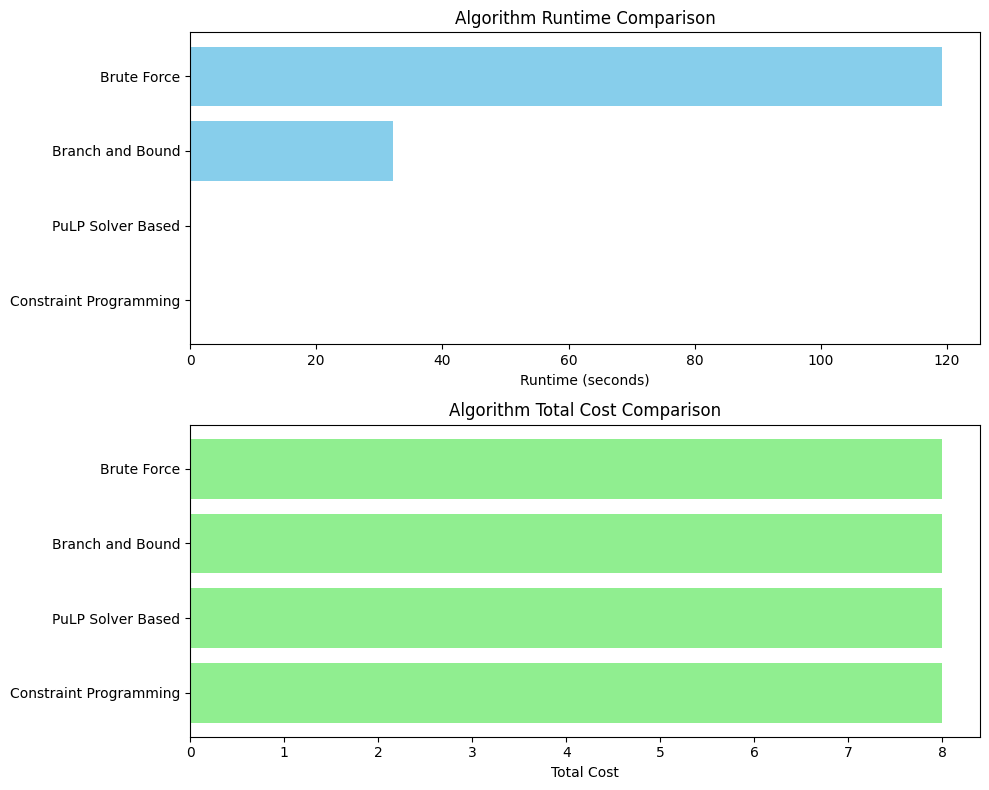

In [58]:
import time
import matplotlib.pyplot as plt

def time_algorithm(func):
    """Wrapper function to time any algorithm."""
    start_time = time.time()
    total_cost, solution = func()  # Execute the algorithm
    end_time = time.time()
    runtime = end_time - start_time
    return runtime, total_cost

def compare_algorithms():
    # Running the algorithms and recording results
    algorithms = [
        ("OR-tools Constraint Programming", ortools_cpmodel_solution),
        ("PuLP Solver Based", pulp_solver_based_solution),
        ("Branch and Bound", branch_and_bound),
        ("Brute Force", brute_force_solution)
    ]

    results = []
    for name, func in algorithms:
        runtime, cost = time_algorithm(func)
        results.append((name, runtime, cost))

    return results

def visualize_results(results):
    # Extracting data for visualization
    names = [name for name, _, _ in results]
    runtimes = [runtime for _, runtime, _ in results]
    costs = [cost for _, _, cost in results]

    # Plotting the runtime comparison
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))

    ax[0].barh(names, runtimes, color='skyblue')
    ax[0].set_xlabel('Runtime (seconds)')
    ax[0].set_title('Algorithm Runtime Comparison')

    # Plotting the total cost comparison
    ax[1].barh(names, costs, color='lightgreen')
    ax[1].set_xlabel('Total Cost')
    ax[1].set_title('Algorithm Total Cost Comparison')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    results = compare_algorithms()
    visualize_results(results)


In [60]:
results

[('Constraint Programming', 0.007509946823120117, 8),
 ('PuLP Solver Based', 0.015808820724487305, 8),
 ('Branch and Bound', 32.100937366485596, 8),
 ('Brute Force', 119.27748370170593, 8)]